In [10]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.stats import rankdata
import pickle
import statistics as stat

Load data, subset to highly variable genes, shift pseudotime to [0,1] scale

In [2]:
endo = sc.read_h5ad('../data/endo.h5ad')
endo = endo[:,endo.var['Selected']==1]
endo.obs['dpt_pseudotime'] = endo.obs['dpt_pseudotime']/max(endo.obs['dpt_pseudotime'])

Trying to set attribute `.obs` of view, copying.


Sneak a peek at how our pseudotime distribution looks for this lineage

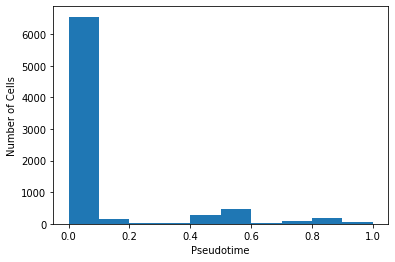

In [4]:
pl.hist(endo.obs['dpt_pseudotime'], bins=10)
pl.xlabel("Pseudotime")
pl.ylabel("Number of Cells")
pl.show()

Define pseudotime decile bins, adjust for library size, and log normalize the data  
Pseudobulk aggregation approach from [Ding et al 2019](https://www.biorxiv.org/content/10.1101/632216v1.full.pdf+html)

In [55]:
_, nG = endo.X.shape
nC = 10
counts = endo.X
t = np.zeros(nC)
numcells = np.zeros(nC)
Y = np.zeros([nC, nG])
bin_w = 1/nC
for c in range(nC):
    endo_c = endo[(c*bin_w <= endo.obs['dpt_pseudotime']) & (endo.obs['dpt_pseudotime'] < (c+1)*bin_w)]
    exp_c = csr_matrix.sum(endo_c.X, 0)/csr_matrix.sum(endo_c.X)
    exp_c = np.log(10**4 * exp_c + 1)
    numcells[c] = endo_c.shape[0]
    Y[int(c),:] = exp_c
    t[int(c)] = np.median(endo_c.obs['dpt_pseudotime'])

Is quantile normalization necessary?  If the distributions of genes across deciles is broadly different, then maybe

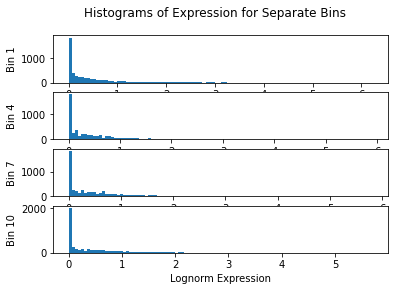

In [37]:
fig, (ax1, ax2, ax3, ax4) = pl.subplots(4)
fig.suptitle('Histograms of Expression for Separate Bins')
ax1.hist(Y[0,:], bins=100)
ax1.set(ylabel="Bin 1")
ax2.hist(Y[3,:], bins=100)
ax2.set(ylabel="Bin 4")
ax3.hist(Y[6,:], bins=100)
ax3.set(ylabel="Bin 7")
ax4.hist(Y[9,:], bins=100)
ax4.set(ylabel="Bin 10", xlabel="Lognorm Expression")
pl.show()
# pl.hist(Y[1,:], bins=100)
# pl.xlabel("Expression")
# pl.ylabel("Number of Genes")
# pl.show()

Quantile normalize the data so each decile bin has a similar distribution across genes (skipping this as it may not be necessary and doesn't seem to be typically used)

In [57]:
def quantile_normalize(data):
    featranks = np.zeros(data.shape, dtype=int)
    normdata = np.zeros(data.shape)
    for i in range(len(featranks)):
        featranks[i,:] = rankdata(data[i,:])
    featranks -= 1
    normexp = np.average(np.sort(data, axis=1), axis=0)
    for i in range(data.shape[0]):
        for g in range(data.shape[1]):
            normdata[i,g] = normexp[featranks[i,g]]
    return(normdata)
# Ynorm = quantile_normalize(Y)
Ynorm=Y

Center and scale

In [59]:
for g in range(Ynorm.shape[1]):
    if stat.stdev(Ynorm[:,g])==0:
        Ynorm[:,g] = np.zeros(10)
    else:
        Ynorm[:,g] = (Ynorm[:,g]-np.mean(Ynorm[:,g]))/stat.stdev(Ynorm[:,g])
Yflat = Ynorm.flatten()

In [46]:
Ynorm.shape

(10, 5000)

Take a look at how some of the key marker genes' expression varies over these bins

In [61]:
genedict = {endo.var.index[i]:i for i in range(len(endo.var.index))}

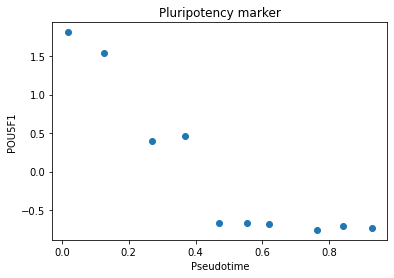

In [62]:
pl.plot(t, Ynorm[:,genedict["POU5F1"]], "o")
pl.ylabel("POU5F1")
pl.xlabel("Pseudotime")
pl.title("Pluripotency marker")
pl.show()

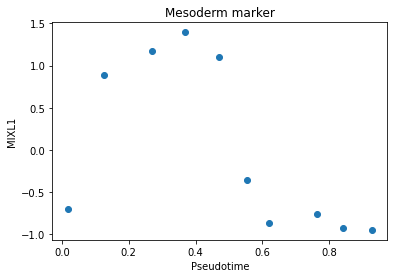

In [63]:
pl.plot(t, Ynorm[:,genedict["MIXL1"]], "o")
pl.ylabel("MIXL1")
pl.xlabel("Pseudotime")
pl.title("Mesoderm marker")
pl.show()

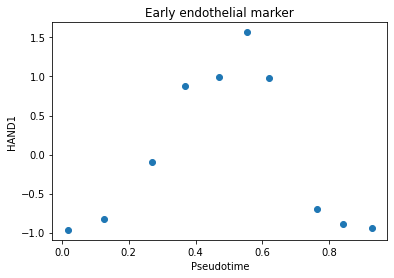

In [64]:
pl.plot(t, Ynorm[:,genedict["HAND1"]], "o")
pl.ylabel("HAND1")
pl.xlabel("Pseudotime")
pl.title("Early endothelial marker")
pl.show()

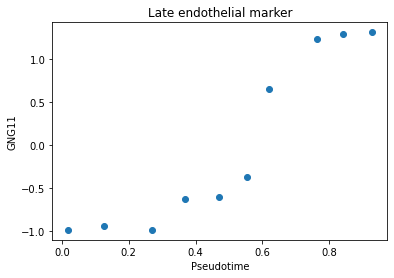

In [65]:
pl.plot(t, Ynorm[:,genedict["GNG11"]], "o")
pl.ylabel("GNG11")
pl.xlabel("Pseudotime")
pl.title("Late endothelial marker")
pl.show()

In [66]:
X = np.zeros([nC*nG,3])
for c in range(nC):
    X[c*nG:((c+1)*nG),0] = t[c]
    X[c*nG:((c+1)*nG),1] = c
    X[c*nG:((c+1)*nG),2] = list(range(nG))

In [67]:
np.savetxt( "../data/endo.X.txt", X)
np.savetxt("../data/endo.Y.txt", Yflat)

In [69]:
with open("../data/genedict.endo.pickle", 'wb') as f:
    pickle.dump(genedict, f)
    f.close()